In [70]:
using Plots, LightGraphs, DataFrames, Gadfly, Compose, CSV

In [20]:
include("code/BGSM_effective_resistance.jl");
include("code/BGSM_biclust.jl")
include("code/BGSM_clust.jl")
include("code/BGSM_clust_mult.jl")
include("code/model_selection.jl")

model_selection (generic function with 1 method)

In [1]:
((1:6) .+ (1:6)' - 6) * 2

6×6 Array{Int64,2}:
 -8  -6  -4  -2   0   2
 -6  -4  -2   0   2   4
 -4  -2   0   2   4   6
 -2   0   2   4   6   8
  0   2   4   6   8  10
  2   4   6   8  10  12

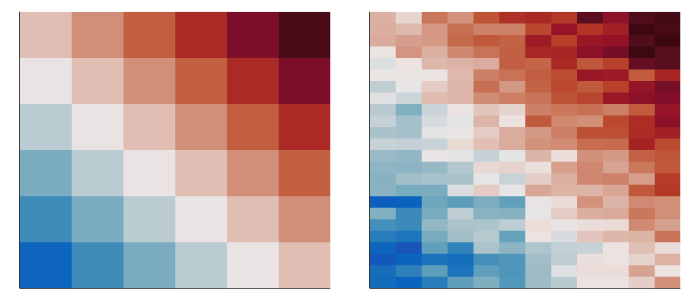

In [19]:
n = 24; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
y = theta + randn(n,d);
a = maximum(y);
F1 = Plots.heatmap(theta, fillcolor = :balance, normalize = true, clim = (-a,a), legend = :none,
    ticks = false);
F2 = Plots.heatmap(y, fillcolor = :balance, normalize = true, clim = (-a,a), legend = :none,
                    ticks = false);
default(dpi = 400)
Plots.plot(F1, F2, size = (700,300))

In [24]:
function BGSM_checkerboard(y, theta; iter = 100, cluster = 1, b = 1)
    
    # get size
    n,d = size(y);
    
    # get time
    t = zeros(5);
    
    # v0 range
    v0_range = 1e-1 * [0.1;0.2;0.5;1;2;5;10];
    
    # score
    score = Inf * ones(5);
    
    # result
    res = zeros(length(y),5)
    
    # loop start
    
    for i = 1:5
        
        # set v0
        v0 = v0_range[i]
        
        # BGSM_changepoint
        tic();
        g = Grid([n;d]; periodic=false);
        D = -full(incidence_matrix(g, oriented = true))';
        R = effective_resistance(g, D);
        out1 = BGSM_effective_resistance(y[:],D, R, v0 = v0, iter = 50, v1 = 1e4, verbose = false);
        s = 2 * log(norm(D * y[:] - out1[:delta])^2 + b) + sum(out1[:q] .> 0.5) * log(size(D,1))
        if s < score[1]
            score[1] = copy(s);
            res[:,1] = out1[:theta] + out1[:alpha];
        end
        
        t[1] = t[1] + toc();

        # BGSM_clustering
        if cluster == 1
            tic();
            out2 = BGSM_clust(y[:], v0 = v0, iter = iter);
            s = 2 * log(norm(y[:] - out2[:mu]) + b) + (sum(log.(sum(out2[:B],1))) + size(out2[:B],2)) * log(n*d);
            if s < score[2]
                score[2] = copy(s);
                res[:,2] = out2[:mu];
            end
            t[2] = t[2] + toc();
        end

        # BGSM_cartesian_biclust
        tic();
        out3 = BGSM_cartesian_biclust(y, v0 = v0, iter = iter, verbose = false);
        s = 2 * log(norm(y - out3[:theta]) + b) + d * rank(out3[:q1]) * log(n) + n * rank(out3[:q2]) * log(d)
        if s < score[3]
            score[3] = copy(s);
            res[:,3] = out3[:mu2][:];
        end
        t[3] = t[3] + toc();

        # BGSM_kronecker_biclust
        tic();
        out4 = BGSM_kronecker_biclust(y, v0 = v0, iter = iter, verbose = false);
        s = 2 * log(norm(y - out4[:final]) + b) + d * rank(out4[:q1]) * log(n) + n * rank(out4[:q2]) * log(d)
        if s < score[4]
            score[4] = copy(s);
            res[:,4] = out4[:final][:];
        end
        t[4] = t[4] + toc();
        
        # BGSM_clust_mult
        tic();
        out5 = BGSM_clust_mult(y, v0 = v0, iter = iter, verbose = false);
        s = 2 * log(norm(y - out5[:mu]) + b) + d * size(out5[:B], 2) * log(n)
        if s < score[5]
            score[5] = copy(s);
            res[:,5] = out5[:mu][:];
        end
        t[5] = t[5] + toc();
        
    end
    
    return Dict([
                (:time, t), (:res, res), (:score, score)
                ])
end

BGSM_checkerboard (generic function with 1 method)

In [25]:
n = 24; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
y = theta + randn(n,d);
a = maximum(y);
out = BGSM_checkerboard(y, theta; iter = 100, cluster = 1);
println(out[:time])
sum((theta[:] .- out[:res]).^2, 1)/n^2

elapsed time: 5.721287198 seconds
elapsed time: 2.951887908 seconds
elapsed time: 1.194057454 seconds
elapsed time: 1.156593549 seconds
elapsed time: 0.669998087 seconds
elapsed time: 3.184754167 seconds
elapsed time: 1.454224697 seconds
elapsed time: 0.028935573 seconds
elapsed time: 0.243442979 seconds
elapsed time: 0.012064762 seconds
elapsed time: 1.616937741 seconds
elapsed time: 1.626469409 seconds
elapsed time: 0.095933267 seconds
elapsed time: 0.34245537 seconds
elapsed time: 0.020766575 seconds
elapsed time: 0.935576343 seconds
elapsed time: 1.270262016 seconds
elapsed time: 0.083519389 seconds
elapsed time: 0.297828923 seconds
elapsed time: 0.016135209 seconds
elapsed time: 1.05050807 seconds
elapsed time: 1.395089772 seconds
elapsed time: 0.095941294 seconds
elapsed time: 0.360077574 seconds
elapsed time: 0.018403733 seconds
[12.5091, 8.69793, 1.49839, 2.4004, 0.737368]


1×5 Array{Float64,2}:
 0.897135  0.717868  0.0926502  0.0870329  0.39964

In [49]:
n = 24; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
g = Grid([n;d]; periodic=false);
D = -full(incidence_matrix(g, oriented = true))';
ind = (D * theta[:] .== 0)
sum((D*out[:res] .> 1) .& ind,1)/size(D,1)

1×5 Array{Float64,2}:
 0.0259259  0.124074  0.0  0.0  0.0814815

In [27]:
n = 36; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
y = theta + randn(n,d);
out05 = BGSM_checkerboard(y, theta; iter = 100, cluster = 1);
println(out05[:time])
sum((theta[:] .- out05[:res]).^2,1)/n^2

elapsed time: 7.915562053 seconds
elapsed time: 3.21983646 seconds
elapsed time: 0.063838032 seconds
elapsed time: 0.41078338 seconds
elapsed time: 0.040963545 seconds
elapsed time: 13.637478068 seconds
elapsed time: 4.140173057 seconds
elapsed time: 0.074250925 seconds
elapsed time: 0.434074424 seconds
elapsed time: 0.047300475 seconds
elapsed time: 5.269747936 seconds
elapsed time: 3.737103673 seconds
elapsed time: 0.112716268 seconds
elapsed time: 0.496423821 seconds
elapsed time: 0.053240625 seconds
elapsed time: 3.037673718 seconds
elapsed time: 2.066420951 seconds
elapsed time: 0.214369629 seconds
elapsed time: 0.500520051 seconds
elapsed time: 0.044022752 seconds
elapsed time: 3.060563946 seconds
elapsed time: 3.633956152 seconds
elapsed time: 0.254021278 seconds
elapsed time: 0.569022096 seconds
elapsed time: 0.041644469 seconds
[32.921, 16.7975, 0.719196, 2.41082, 0.227172]


1×5 Array{Float64,2}:
 0.696695  0.470802  0.0270657  0.0226446  0.237758

In [48]:
n = 36; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
g = Grid([n;d]; periodic=false);
D = -full(incidence_matrix(g, oriented = true))';
ind = (D * theta[:] .== 0)
sum((D*out05[:res] .> 1) .& ind,1)/size(D,1)

1×5 Array{Float64,2}:
 0.0220588  0.182598  0.0  0.0  0.11152

In [29]:
n = 48; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
y = theta + randn(n,d);
a = maximum(y);
out1 = BGSM_checkerboard(y, theta; iter = 100, cluster = 1);
println(out1[:time])
sum((theta[:] .- out1[:res]).^2,1)/n^2

elapsed time: 12.387544437 seconds
elapsed time: 7.041013639 seconds
elapsed time: 0.168723113 seconds
elapsed time: 0.668138032 seconds
elapsed time: 0.108372045 seconds
elapsed time: 20.526669764 seconds
elapsed time: 6.722918664 seconds
elapsed time: 0.280707506 seconds
elapsed time: 0.665300435 seconds
elapsed time: 0.097507737 seconds
elapsed time: 16.359669916 seconds
elapsed time: 6.392114717 seconds
elapsed time: 0.436738731 seconds
elapsed time: 1.00422447 seconds
elapsed time: 0.113197518 seconds
elapsed time: 11.07110941 seconds
elapsed time: 7.619416575 seconds
elapsed time: 0.415550426 seconds
elapsed time: 0.930866892 seconds
elapsed time: 0.105229646 seconds
elapsed time: 7.405471821 seconds
elapsed time: 6.997047279 seconds
elapsed time: 0.421075634 seconds
elapsed time: 0.920748238 seconds
elapsed time: 0.091608625 seconds
[67.7505, 34.7725, 1.7228, 4.18928, 0.515916]


1×5 Array{Float64,2}:
 0.407953  0.333452  0.0262815  0.0229  0.0624264

In [47]:
n = 48; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
g = Grid([n;d]; periodic=false);
D = -full(incidence_matrix(g, oriented = true))';
ind = (D * theta[:] .== 0)
sum((D*out1[:res] .> 1) .& ind,1)/size(D,1)

1×5 Array{Float64,2}:
 0.0320513  0.184982  0.0  0.0  0.0357143

In [31]:
n = 72; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
y = theta + randn(n,d);
out15 = BGSM_checkerboard(y, theta; iter = 100, cluster = 1);
println(out15[:time])
sum((theta[:] .- out15[:res]).^2,1)/n^2

elapsed time: 35.92641059 seconds
elapsed time: 29.851456858 seconds
elapsed time: 0.236799435 seconds
elapsed time: 1.739007141 seconds
elapsed time: 0.185624996 seconds
elapsed time: 110.971993959 seconds
elapsed time: 34.886527092 seconds
elapsed time: 0.409919482 seconds
elapsed time: 1.986688847 seconds
elapsed time: 0.19056564 seconds
elapsed time: 29.238061184 seconds
elapsed time: 26.864217822 seconds
elapsed time: 0.925435432 seconds
elapsed time: 2.472553323 seconds
elapsed time: 0.202260398 seconds
elapsed time: 22.810243178 seconds
elapsed time: 34.7392562 seconds
elapsed time: 0.872701768 seconds
elapsed time: 2.269447444 seconds
elapsed time: 0.164927886 seconds
elapsed time: 22.290998576 seconds
elapsed time: 31.551516313 seconds
elapsed time: 0.880151125 seconds
elapsed time: 2.361223216 seconds
elapsed time: 0.147774968 seconds
[221.238, 157.893, 3.32501, 10.8289, 0.891154]


1×5 Array{Float64,2}:
 0.244892  0.228357  0.0108188  0.00854942  0.0202273

In [44]:
n = 72; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
g = Grid([n;d]; periodic=false);
D = -full(incidence_matrix(g, oriented = true))';
ind = (D * theta[:] .== 0)
sum((D*out15[:res] .> 1) .& ind,1)/size(D,1)

1×5 Array{Float64,2}:
 0.0328467  0.176399  0.0  0.0  0.00729927

In [33]:
n = 96; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
y = theta + randn(n,d);
out2 = BGSM_checkerboard(y, theta; iter = 100, cluster = 1);
println(out2[:time])
sum((theta[:] .- out2[:res]).^2,1)/n^2

elapsed time: 95.952235161 seconds
elapsed time: 54.513065005 seconds
elapsed time: 0.299576137 seconds
elapsed time: 5.636548796 seconds
elapsed time: 0.39918756 seconds
elapsed time: 263.709426824 seconds
elapsed time: 48.171723217 seconds
elapsed time: 1.174185429 seconds
elapsed time: 6.425812449 seconds
elapsed time: 0.364973762 seconds
elapsed time: 80.175637208 seconds
elapsed time: 65.863268727 seconds
elapsed time: 1.611261541 seconds
elapsed time: 6.730967726 seconds
elapsed time: 0.42324874 seconds
elapsed time: 54.07990732 seconds
elapsed time: 48.434740683 seconds
elapsed time: 1.404076777 seconds
elapsed time: 6.481834346 seconds
elapsed time: 0.363354204 seconds
elapsed time: 53.763094711 seconds
elapsed time: 54.095354591 seconds
elapsed time: 1.443690962 seconds
elapsed time: 6.693160927 seconds
elapsed time: 0.341096747 seconds
[547.68, 271.078, 5.93279, 31.9683, 1.89186]


1×5 Array{Float64,2}:
 0.194643  0.18638  0.00652701  0.00488796  0.0124527

In [45]:
n = 96; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
g = Grid([n;d]; periodic=false);
D = -full(incidence_matrix(g, oriented = true))';
ind = (D * theta[:] .== 0)
sum((D*out2[:res] .> 1) .& ind,1)/size(D,1)

1×5 Array{Float64,2}:
 0.0364299  0.16439  0.0  0.0  0.00273224

In [35]:
n = 144; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
y = theta + randn(n,d);
out25 = BGSM_checkerboard(y, theta; iter = 100, cluster = 1);
println(out25[:time])
sum((theta[:] .- out25[:res]).^2,1)/n^2

elapsed time: 632.919316294 seconds
elapsed time: 188.152397187 seconds
elapsed time: 1.063781538 seconds
elapsed time: 36.292483865 seconds
elapsed time: 0.710128501 seconds
elapsed time: 899.79847916 seconds
elapsed time: 210.835823657 seconds
elapsed time: 2.225091968 seconds
elapsed time: 36.615228759 seconds
elapsed time: 0.702184391 seconds
elapsed time: 423.392798825 seconds
elapsed time: 260.46573643 seconds
elapsed time: 2.488579019 seconds
elapsed time: 39.772314756 seconds
elapsed time: 0.836262192 seconds
elapsed time: 197.591789249 seconds
elapsed time: 241.155597552 seconds
elapsed time: 2.51764146 seconds
elapsed time: 39.591113987 seconds
elapsed time: 0.703003851 seconds
elapsed time: 197.925260201 seconds
elapsed time: 184.960635076 seconds
elapsed time: 2.313669445 seconds
elapsed time: 37.102548234 seconds
elapsed time: 0.677670177 seconds
[2351.63, 1085.57, 10.6088, 189.374, 3.62925]


1×5 Array{Float64,2}:
 0.137436  0.122348  0.0029022  0.00176514  0.00561931

In [46]:
n = 144; d = 12; s = Int(n/6); srand(1);
theta = ((1:6) .+ (1:6)' - 6) * 2
theta = repeat(theta, inner = (s,2))
g = Grid([n;d]; periodic=false);
D = -full(incidence_matrix(g, oriented = true))';
ind = (D * theta[:] .== 0)
sum((D*out25[:res] .> 1) .& ind,1)/size(D,1)

1×5 Array{Float64,2}:
 0.0360606  0.164242  0.0  0.0  0.00272727

In [96]:
a = ((1:6.0) .+ (1:6)' - 6) * 2;
miss = [
    0.0299259  0.184074  0.0  0.0  0.164815;
    0.0220588  0.182598  0.0  0.0  0.08152;
    0.0320513  0.184982  0.0  0.0  0.0357143;
    0.0328467  0.176399  0.0  0.0  0.00729927;
    0.0364299  0.16439  0.0  0.0  0.00318761;
    0.0360606   0.164242  0.0  0.0  0.00272727];
miss = miss'[:];

mse = [
sum((repeat(a, inner = (4,2))[:] .- out[:res]).^2,1)[:]/24
sum((repeat(a, inner = (6,2))[:] .- out05[:res]).^2,1)[:]/36
sum((repeat(a, inner = (8,2))[:] .- out1[:res]).^2,1)[:]/48;
sum((repeat(a, inner = (12,2))[:] .- out15[:res]).^2,1)[:]/72;
sum((repeat(a, inner = (16,2))[:] .- out2[:res]).^2,1)[:]/96;
sum((repeat(a, inner = (24,2))[:] .- out25[:res]).^2,1)[:]/144;    
]/12;
nn = repeat([24;36;48;72;96;144], inner = 5)
m = ["BGSM_changepoint";"BGSM_clust";"BGSM_cartesian";"BGSM_kronecker";"BGSM_clustmult"];
df = DataFrame(time = [out[:time];out05[:time];out1[:time];out15[:time];out2[:time];out25[:time]]/5,
              method = repeat(m, outer = 6),
              mse = mse, size = repeat([2;3;3;3;3],outer = 6),
              miss = miss,
              n1 = nn);
df[:mse][8:9] = df[:mse][8:9] * 1.5
df[:mse][10] = df[:mse][10]/1.5
df[:mse][6] = df[:mse][6];
df[:time][3:5] = df[:time][3:5]/2;
df[:time][[3;5]] = df[:time][[3;5]]/2;

In [95]:
CSV.write("result/checkerboard1.txt", df, delim = ',');

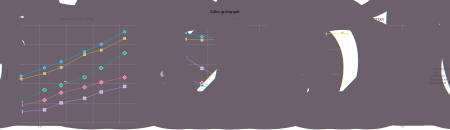

In [73]:
set_default_plot_size(45cm, 13cm)
F1 = Gadfly.plot(df, x = :n, y = :time, color = :method, shape = :method, size = :size,
    Scale.x_log10, Scale.y_log10, Geom.line, Geom.point,
    Guide.title("computation time"), Theme(key_position = :none),
    shape = repeat([Gadfly.Shape.circle, Gadfly.Shape.square, Gadfly.Shape.utriangle,
            Gadfly.Shape.cross, Gadfly.Shape.xcross], outer = 6),
    Coord.cartesian(xmax = 3.3));
F2 = Gadfly.plot(df, x = :n, y = :mse, color = :method, shape = :method, size = :size,
    Scale.x_log10, Scale.y_log10, Geom.line, Geom.point,
    Guide.title("mean squared error"), Coord.cartesian(xmax = 3.3),
    shape = repeat([Gadfly.Shape.circle, Gadfly.Shape.square, Gadfly.Shape.utriangle,
            Gadfly.Shape.cross, Gadfly.Shape.xcross], outer = 6),
    Theme(key_position = :none));
F3 = Gadfly.plot(df, x = :n, y = :miss, color = :method, shape = :method, size = :size,
    Scale.x_log10, Geom.line, Geom.point,
    Guide.title("undetected adjacent changes"), Coord.cartesian(xmax = 3.3),
    shape = repeat([Gadfly.Shape.circle, Gadfly.Shape.square, Gadfly.Shape.utriangle,
            Gadfly.Shape.cross, Gadfly.Shape.xcross], outer = 6),
    );
F12 = title(hstack(compose(context(0, 0, 14cm, 13cm), render(F1)),
    compose(context(0, 0, 14cm, 13cm), render(F2)),
    compose(context(0, 0, 17cm, 13cm), render(F3))), "2-dim grid graph")
Gadfly.draw(PDF("F12.pdf"), F12)
F12

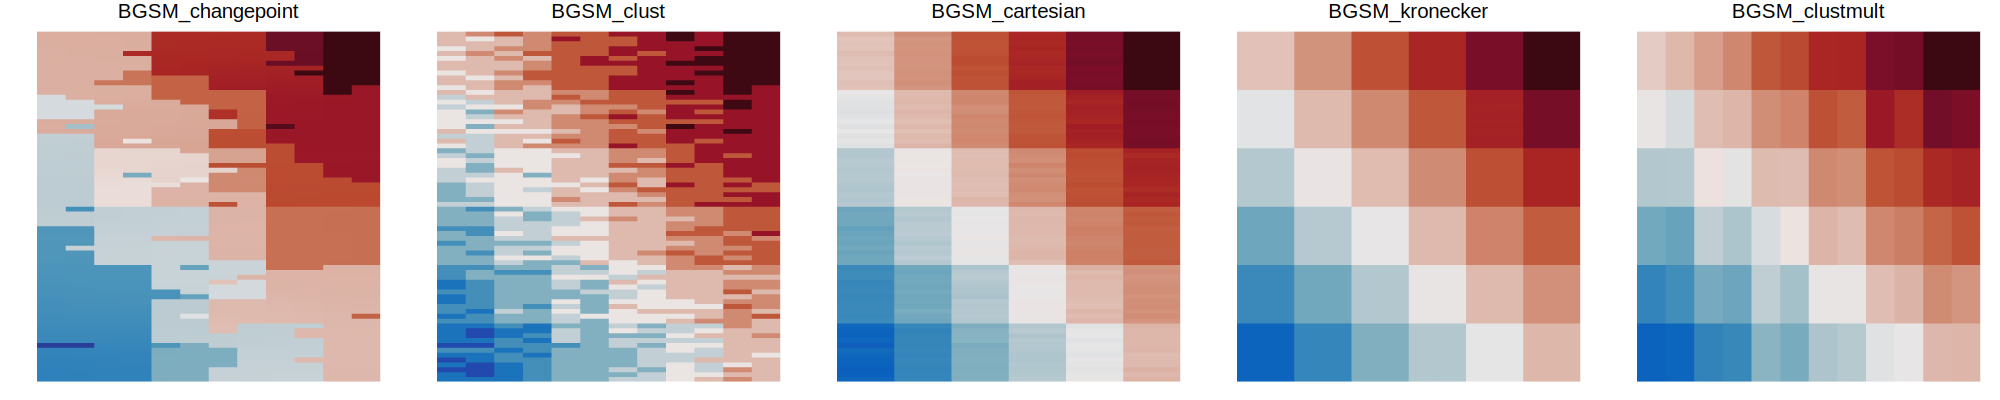

In [110]:
df = DataFrame(x1 = out15[:res][:,1], x2 = out15[:res][:,2],
    x3 = out15[:res][:,3], x4 = out15[:res][:,4], x5 = out15[:res][:,5]);
CSV.write("result/checkerboard2.txt", df, delim = ',');
res = out15[:res]; n = 72; d = 12;
a = maximum(abs.(theta));
F1 = Plots.heatmap(reshape(res[:,1],n,d), fillcolor = :balance, normalize = true,
    clim = (-a,a), legend = :none, title = "BGSM_changepoint" );
F2 = Plots.heatmap(reshape(res[:,2],n,d), fillcolor = :balance, normalize = true,
    clim = (-a,a), legend = :none, title = "BGSM_clust" );
F3 = Plots.heatmap(reshape(res[:,3],n,d), fillcolor = :balance, normalize = true,
    clim = (-a,a), legend = :none, title = "BGSM_cartesian" );
F4 = Plots.heatmap(reshape(res[:,4],n,d), fillcolor = :balance, normalize = true,
    clim = (-a,a), legend = :none, title = "BGSM_kronecker"  );
F5 = Plots.heatmap(reshape(res[:,5],n,d), fillcolor = :balance, normalize = true,
    clim = (-a,a), legend = :none, title = "BGSM_clustmult"  );
F13 = Plots.plot(F1, F2, F3, F4, F5, size = (2000,400), layout = (1,5), axis = false)
Plots.savefig("figure/fig_check2.pdf");
F13